Imagine that you're a wildlife biologist, and you're conducting a study on the activity habits of whitetail deer.  
<img src="images/deer.jpg">
As any hunter knows, deer activity varies depending on time of day, and this time-varying level of activity is what you're tasked with quantifying.  In particular, what you want to do is to fit a model that asks the question: if I am sitting at a particular spot at a particular time of day, what is the probability that I will see a whitetail deer?  

In principle, this is precisely the type of question that we might be interested in using logistic regression for.  We have a feature $\mathbf{x}$, which is the time of day, as well as a binary outcome $y\in\{0,1\}$ (whether we see a deer or not) for which we'd like to generate a probability.  What do we need to fit this model?  

Of course, to begin with we'll need a dataset.  To collect such a dataset we could simply put out a camera (strapped to a tree, for example), set it to take pictures at random and determine whether there is a deer in the image (we could determine this by hand or using a machine learning algorithm to automatically process the image, something that we'll get to in this course!).  In full disclosure, the dataset that I'll provide here is synthetically generated (i.e. it's from a simulation).  However, let's suspend disbelief and imagine that we've done what we described above. 

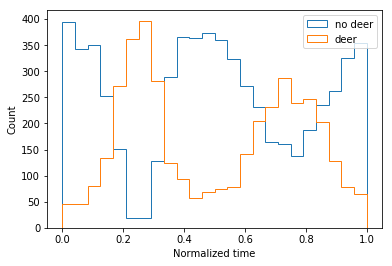

In [41]:
import numpy as np
import matplotlib.pyplot as plt
x,y = np.loadtxt('deer.npy')
y_obs = np.reshape(y,(len(y),1))

plt.hist(x[y==0],bins=24,histtype='step',label='no deer')
plt.hist(x[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()
plt.show()

Now we'd like to fit a logistic regression model.  As with the lobster problem, it's helpful to have normalized features so that gradient descent converges easily.  We can basically lift the code from that problem for running gradient descent:

In [62]:
def sigmoid(a):
    return 1./(1+np.exp(-a))

def L(y_obs,y_pred):
    return -1./len(y_obs)*np.sum(y_obs*np.log(y_pred) + (1-y_obs)*np.log(1-y_pred))

def grad(y_obs,y_pred,phi):
    return phi.T @ (y_pred-y_obs)

w = np.random.randn(2,1)
phi = np.vstack((np.ones_like(x),x)).T

eta = 1e-4
for i in range(20):
    y_pred = sigmoid(phi @ w)
    w -= eta*grad(y_obs,y_pred,phi)  
    print(L(y_obs,y_pred))

0.8783985325021996
0.8002633449981533
0.7467821911408865
0.7131887787274456
0.693586164740928
0.6827773773404627
0.6770503476150378
0.6740934404804538
0.6725890854612226
0.6718274320036958
0.6714394491656931
0.671237600516216
0.6711279674768084
0.6710639608410849
0.6710226119108645
0.6709926407713429
0.6709685193356202
0.6709475392538925
0.670928371059797
0.6709103585124664


This is a pretty easy problem, so gradient descent converges in just a handful of iterations.  Let's plot our predictions.  We'll just plot the histograms from before, as well as the outut of the sigmoid. 

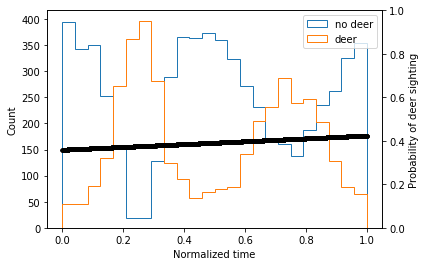

In [63]:
plt.hist(x[y==0],bins=24,histtype='step',label='no deer')
plt.hist(x[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()
ax = plt.twinx()
ax.plot(x,y_pred,'k.')
ax.set_ylabel('Probability of deer sighting')
ax.set_ylim(0,1)
plt.show()

Huh.

It appears to be the case that logistic regression is telling us that there always about a 40% chance of seeing a deer, regardless of the time of day.  While this is a bit underwhelming, logistic regression is actually performing as well as can be expected in this case: gradient descent has been successful, and this is indeed the optimized model.  Please answer the following two questions:
- **Why is the model predicting a uniform value for the probability, even though the data clearly show probability as a function of time?**
- **Why does the model predict 40% everywhere?**

We can perhaps gain some insight here by attempting to adjust the sigmoid by hand.  Let's start with some random one.

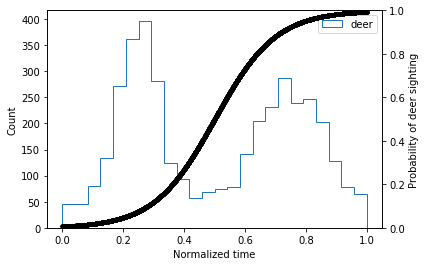

In [71]:
plt.hist(x[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()

ax = plt.twinx()
w_random = np.array([-5,10])
y_pred = sigmoid(phi@w_random)
ax.plot(x,y_pred,'k.')
ax.set_ylabel('Probability of deer sighting')
ax.set_ylim(0,1)
plt.show()

We want this curve to be high whenever the sighting count is high and low otherwise.  We have two modes of adjustment.  We can vary $w_0$, which does this:

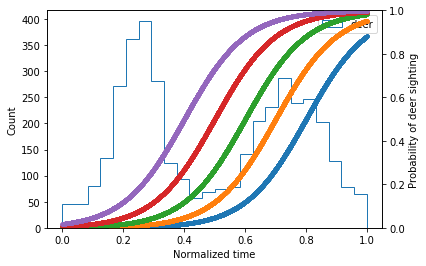

In [72]:
plt.hist(x[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()

ax = plt.twinx()
for w_0 in range(-8,-3):
    w_random = np.array([w_0,10])
    y_pred = sigmoid(phi@w_random)
    ax.plot(x,y_pred,'.')
ax.set_ylabel('Probability of deer sighting')
ax.set_ylim(0,1)
plt.show()

Or we can adjust $w_1$, which does this:

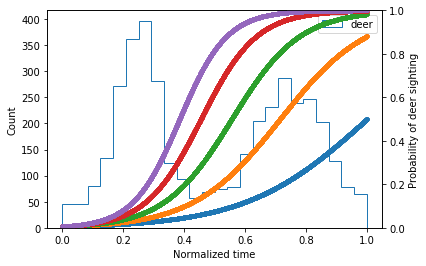

In [76]:
plt.hist(x[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()

ax = plt.twinx()
for w_1 in range(5,15,2):
    w_random = np.array([-5,w_1])
    y_pred = sigmoid(phi@w_random)
    ax.plot(x,y_pred,'.')
ax.set_ylabel('Probability of deer sighting')
ax.set_ylim(0,1)
plt.show()

**Is there a good way to adjust the logistic function using these two knobs such that it gives a good prediction everywhere?**  The answer, of course, is no: the bimodality of the data makes it so that it's quite impossible for the logistic function, which can only split the domain into one region each of high probability and low probability, to fit well.  As such, the optimization procedure essentially throws up its hands and says "the best I can do is to default to the prior distribution, which is about a 40% chance of success.  This is pretty much what will *always* happen with logistic regression whenever there isn't a single point that represents a sensible decision boundary between the success and failure class (this boundary becomes a line in 2D, a plane in 3D, and so on).

## 5.2 Data transformation
The problem isn't necessarily hopeless though.  Notice that the features are fixed and known.  As such, we could try to transform the features into something that is more amenable to the assumptions of logistic regression.  To put this concretely, rather than using $x$ (the time) as a feature, we could use $f(x)$ as a feature, where $f(x)$ is some function that we can choose.  For example, we could hypothesize that maybe taking the negative exponential of the feature might yield a better behaved problem: 

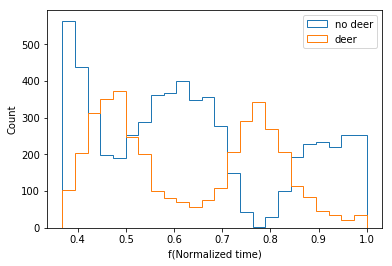

In [96]:
xhat = np.exp(-x)
plt.hist(xhat[y==0],bins=24,histtype='step',label='no deer')
plt.hist(xhat[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('f(Normalized time)')
plt.ylabel('Count')
plt.legend()
plt.show()

But of course it doesn't, because $f(x) = \mathrm{e}^{-x}$ is monotonic.  **Come up with some function that would transform the data such that the notion of a single, pointwise decision boundary becomes more reasonable.** 

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 3937.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.]),
 array([0.5       , 0.54166667, 0.58333333, 0.625     , 0.66666667,
        0.70833333, 0.75      , 0.79166667, 0.83333333, 0.875     ,
        0.91666667, 0.95833333, 1.        , 1.04166667, 1.08333333,
        1.125     , 1.16666667, 1.20833333, 1.25      , 1.29166667,
        1.33333333, 1.375     , 1.41666667, 1.45833333, 1.5       ]),
 <a list of 1 Patch objects>)

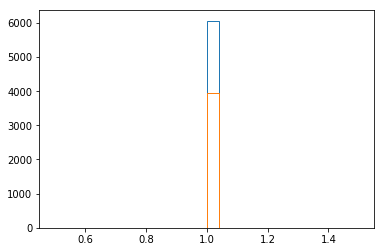

In [98]:
def f(x):
    """ Define a function that transforms the data into something that can be used with logistic regression."""
    return np.ones_like(x)  # This is just a placeholder

xhat = f(x)
plt.hist(xhat[y==0],bins=24,histtype='step',label='no deer')
plt.hist(xhat[y==1],bins=24,histtype='step',label='deer')
plt.show()

<img src="images/fighting.jpg">

Once you've completed the above exercise, you can look at the very reasonable choice that I've suggested below.

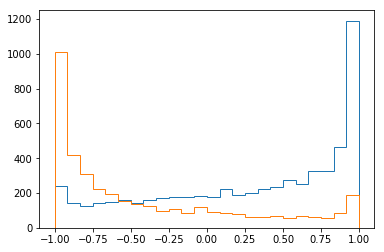

In [100]:
xhat = np.cos(4*np.pi*x)
plt.hist(xhat[y==0],bins=24,histtype='step',label='no deer')
plt.hist(xhat[y==1],bins=24,histtype='step',label='deer')
plt.show()


By taking the cosine (adjusted for twice-daily surge of deer activity), we transform the data into two unimodal populations, which is just what we'd like for using logistic regression.  In fact, we can fit this dataset using logistic regression pretty well.

In [104]:
w = np.random.randn(2,1)
phi = np.vstack((np.ones_like(xhat),xhat)).T

eta = 1e-3
for i in range(50):
    y_pred = sigmoid(phi @ w)
    w -= eta*grad(y_obs,y_pred,phi)  
    print(L(y_obs,y_pred))

0.7940072050424825
0.6052969433620049
0.5911390202007147
0.5792464575242781
0.5669711216425805
0.5620574711165549
0.557498052069953
0.55535841274956
0.5532657016855005
0.5521161116780517
0.5509743962876777
0.5502828606340603
0.5496043239208516
0.549165273788198
0.5487431216552593
0.5484562980484741
0.5481863230867056
0.5479958538512316
0.5478201059750508
0.5476923838012124
0.54757660487386
0.547490454425763
0.5474135543432738
0.5473552396003363
0.5473038688383909
0.5472643140951754
0.547229857205303
0.5472029959374921
0.5471798160956144
0.5471615637097135
0.5471459368244855
0.5471335308835568
0.5471229793189542
0.5471145465875147
0.5471074136451856
0.547101681927847
0.5470968557689124
0.5470929603657684
0.5470896928064529
0.5470870457749759
0.5470848323414256
0.5470830338780935
0.5470815339161598
0.5470803121680056
0.5470792953882584
0.5470784655298728
0.5470777761195837
0.547077212515273
0.5470767449837196
0.5470763622481231


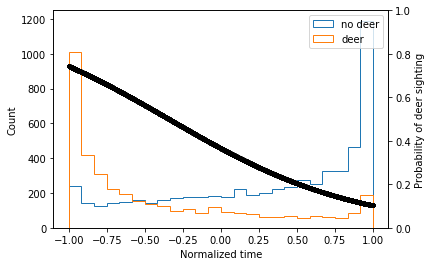

In [105]:
plt.hist(xhat[y==0],bins=24,histtype='step',label='no deer')
plt.hist(xhat[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()
ax = plt.twinx()
ax.plot(xhat,y_pred,'k.')
ax.set_ylabel('Probability of deer sighting')
ax.set_ylim(0,1)
plt.show()

In $f(x)=\mathrm{cos \;4\pi x}$-space, we get a pretty nice fit to the data.  However, it's easier to interpret back in normal $x$ space.  Since the transformation between $x$ and $f(x)$ is fixed and known, it's easy to plot the probabilities as a function of $x$, rather than as a function of $f(x)$.

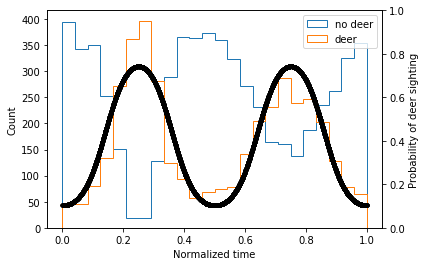

In [103]:
plt.hist(x[y==0],bins=24,histtype='step',label='no deer')
plt.hist(x[y==1],bins=24,histtype='step',label='deer')
plt.xlabel('Normalized time')
plt.ylabel('Count')
plt.legend()
ax = plt.twinx()
ax.plot(x,y_pred,'k.')
ax.set_ylabel('Probability of deer sighting')
ax.set_ylim(0,1)
plt.show()

Pretty nice.  We've established that even though logistic regression doesn't work very well for certain patterns of data (i.e. bimodal data), it can work very well if we can transform the features such that the assumptions of logistic regression are satisfied.

## 5.3 The trouble
While data transformation is very powerful, using it as we did above becomes problematic in more challenging cases.  In particular, our capacity to use expert judgement to come up with a sensible function to use as a transformation mechanism becomes prohibitive as the dimensionality of the data becomes large.  Thus, we need to come up with an *automatic* method for transforming this data such that it is amenable for use in logistic (or softmax) regression. 